# Master Dataset

The goal of this notebook is to gather, clean and join all relevant gas and power price data with the two provided competitor datasets. The output of this notebook is two csv files, one for gas and one for power, containing additional features, cleaned data and correct indexing and data types which can be used for analysis. 

In [1]:
import numpy as np
import pandas as pd
import sklearn as sk
import matplotlib.pyplot as plt

In [2]:
#path to the data folder, edit if necesssary
path = "./data/"

#filenames
file_power = "competitor_market_prices_power.csv"
file_gas = "competitor_market_prices_gas.csv"

#Gas Prices 
spot_gas = "eex_spot_gas.csv"
d_ahead_gas = "eex_gas_d.csv"
m_ahead_gas = "eex_gas_m.csv"
y_ahead_gas = "eex_gas_y.csv"

#Power Prices
spot_power = "epex_spot_power.csv"
d_ahead_peak = "eex_power_peak_d.csv"
m_ahead_peak = "eex_power_peak_m.csv"
y_ahead_peak = "eex_power_peak_y.csv"
d_ahead_base = "eex_power_base_d.csv"
m_ahead_base = "eex_power_base_m.csv"
y_ahead_base = "eex_power_base_y.csv"

In [3]:
#Reading in original datasets
competitors_power = pd.read_csv(path + file_power)
competitors_gas = pd.read_csv(path + file_gas)

In [4]:
#Averaging out exact duplicate rows 

#Defining groupby cols
gb_cols = ['date_valid_from',
            'date_valid_to',
           'post_code', 
           'city', 
           'energy', 
           'consumption_range_kwh', 
           'supplier', 
           'tariff']

agg_dict = {'rank':'mean',
           'price_year_eur':'mean'}


df_power = competitors_power.groupby(gb_cols).agg(agg_dict).reset_index()
df_gas = competitors_gas.groupby(gb_cols).agg(agg_dict).reset_index()

In [5]:
#Joining Price Data
df_spot_power = pd.read_csv(path + spot_power, usecols = [0,1])
df_m_ahead_peak = pd.read_csv(path + m_ahead_peak, usecols = [0,2,7])
df_m_ahead_base = pd.read_csv(path + m_ahead_base, usecols = [0,2,7])
df_y_ahead_peak = pd.read_csv(path + y_ahead_peak, usecols = [0,1,2,3])
df_y_ahead_base = pd.read_csv(path + y_ahead_base, usecols = [0,1,2,3])
df_d_ahead_peak = pd.read_csv(path + d_ahead_peak, usecols = [0,1])
df_d_ahead_base = pd.read_csv(path + d_ahead_base, usecols = [0,1])

In [6]:
df_m_ahead_base

,date,M01,M06
0,2022-10-13,336.63,383.04
1,2022-10-12,341.97,389.53
2,2022-10-11,345.31,398.27
3,2022-10-10,344.89,389.71
4,2022-10-09,344.89,389.71
...,...,...,...
1993,2017-04-29,NaN,NaN
1994,2017-04-28,31.43,33.78
1995,2017-04-27,30.91,34.00
1996,2017-04-26,30.92,33.50


In [7]:
#Renaming columns
df_spot_power.rename(columns = {'d': 'spot'}, inplace = True)
df_y_ahead_peak.rename(columns = {'y01': 'y_ahead_peak',
                                 'y02': '2y_ahead_peak',
                                 'y03': '3y_ahead_peak'}, inplace = True)
df_y_ahead_base.rename(columns = {'y01': 'y_ahead_base',
                                 'y02': '2y_ahead_base',
                                 'y03': '3y_ahead_base'}, inplace = True)
df_d_ahead_peak.rename(columns = {'d00': 'd_ahead_peak'}, inplace = True)
df_d_ahead_base.rename(columns = {'d00': 'd_ahead_base'}, inplace = True)
df_m_ahead_base.rename(columns = {'M01': 'm_ahead_base',
                                 'M06': '6m_ahead_base'}, inplace = True)
df_m_ahead_peak.rename(columns = {'m01': 'm_ahead_peak',
                                 'm06': '6m_ahead_peak'}, inplace = True)

In [8]:
#Indexing Spot Price Data
df_spot_power.time = pd.to_datetime(df_spot_power.time)
df_spot_power['Dates'] = df_spot_power['time'].dt.date
df_spot_power.set_index('time', inplace = True)

In [9]:
#Generating Daily Peak and Base Prices
df_spot_power_peak = df_spot_power.between_time("08:00", "19:59")
df_spot_power_base = df_spot_power.groupby('Dates').mean()
df_spot_power_peak = df_spot_power_peak.groupby('Dates').mean()

#Renaming the columns and joining
df_spot_power_peak.rename(columns = {'spot': 'spot_peak'}, inplace = True)
df_spot_power_base.rename(columns = {'spot': 'spot_base'}, inplace = True)

#Joining the dataset
df_spot_power = pd.merge(df_spot_power_peak,df_spot_power_base, how='inner', left_index=True, right_index=True)


In [10]:
df_y_ahead_peak

,date,y_ahead_peak,2y_ahead_peak,3y_ahead_peak
0,2022-10-13,584.15,353.50,248.16
1,2022-10-12,590.00,355.46,253.61
2,2022-10-11,585.40,355.50,253.50
3,2022-10-10,581.64,353.67,254.50
4,2022-10-09,581.64,353.67,254.50
...,...,...,...,...
1993,2017-04-29,NaN,NaN,NaN
1994,2017-04-28,37.30,35.44,35.87
1995,2017-04-27,37.10,35.33,35.77
1996,2017-04-26,37.06,35.30,35.70


In [11]:
#Joining all price data into master data
from datetime import datetime, timedelta

#Setting join date as index for joining to avoid lookahead bias
df_power.date_valid_from = pd.to_datetime(df_power.date_valid_from)
df_power.index = df_power.date_valid_from - timedelta(days = 1)


#Joining all price data
power_price_dfs = [df_y_ahead_peak, df_y_ahead_base, df_d_ahead_peak, df_d_ahead_base, df_m_ahead_base, df_m_ahead_peak]

for df in power_price_dfs:
    
    df.set_index(pd.to_datetime(df.date), inplace = True)
    df.drop(columns = ['date'], inplace = True)
    df_spot_power = df_spot_power.join(df)
    
df_power_prices = df_spot_power
    
#df_power_prices = df_power_prices.loc[df_power_prices.index >= "2021-05-24"].copy()
df_power_prices.ffill(inplace = True)

In [12]:
df_power_prices

,spot_peak,spot_base,y_ahead_peak,2y_ahead_peak,3y_ahead_peak,y_ahead_base,2y_ahead_base,3y_ahead_base,d_ahead_peak,d_ahead_base,m_ahead_base,6m_ahead_base,m_ahead_peak,6m_ahead_peak
Dates,,,,,,,,,,,,,,
2000-06-16,20.503333,17.126250,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-06-17,15.180000,13.297083,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-06-18,12.578333,11.401667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-06-19,21.919167,17.666250,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-06-20,22.856667,18.363750,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-10-10,186.518333,162.090000,581.64,353.67,254.50,427.00,270.00,195.00,186.52,162.09,344.89,389.71,470.80,492.09
2022-10-11,291.780833,259.873750,585.40,355.50,253.50,435.64,270.00,194.92,291.78,259.87,345.31,398.27,469.67,492.92
2022-10-12,299.796667,282.535833,590.00,355.46,253.61,434.00,268.00,193.88,299.80,282.54,341.97,389.53,454.50,485.41


In [13]:
#Joining all prices with df_power
df_power = df_power.join(df_power_prices)

In [14]:
df_power

,date_valid_from,date_valid_to,post_code,city,energy,consumption_range_kwh,supplier,tariff,rank,price_year_eur,...,3y_ahead_peak,y_ahead_base,2y_ahead_base,3y_ahead_base,d_ahead_peak,d_ahead_base,m_ahead_base,6m_ahead_base,m_ahead_peak,6m_ahead_peak
2021-05-24,2021-05-25,2021-09-21,51103,Köln,power,500,Criador,Meltan,3.0,260.25,...,70.45,64.2,61.08,59.28,26.46,31.65,64.02,75.35,70.28,90.30
2021-05-24,2021-05-25,2021-09-21,51381,Leverkusen,power,500,Criador,Meltan,3.0,257.85,...,70.45,64.2,61.08,59.28,26.46,31.65,64.02,75.35,70.28,90.30
2021-05-24,2021-05-25,2021-09-21,51469,Bergisch Gladbach,power,500,Criador,Meltan,3.0,257.85,...,70.45,64.2,61.08,59.28,26.46,31.65,64.02,75.35,70.28,90.30
2021-05-24,2021-05-25,2021-09-22,51103,Köln,power,250,Criador,Meltan,3.0,187.62,...,70.45,64.2,61.08,59.28,26.46,31.65,64.02,75.35,70.28,90.30
2021-05-24,2021-05-25,2021-09-22,51381,Leverkusen,power,250,Criador,Meltan,2.5,186.42,...,70.45,64.2,61.08,59.28,26.46,31.65,64.02,75.35,70.28,90.30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-10-14,2022-10-15,9999-12-31,99089,Erfurt,power,12000,Werra,Banette,9.0,9257.05,...,248.16,424.0,268.01,185.24,287.57,257.46,336.63,383.04,449.29,473.85
2022-10-14,2022-10-15,9999-12-31,99089,Erfurt,power,12000,Werra,Meditite,12.0,9375.86,...,248.16,424.0,268.01,185.24,287.57,257.46,336.63,383.04,449.29,473.85
2022-10-14,2022-10-15,9999-12-31,99089,Erfurt,power,20000,Lule älv,Pidove,7.0,15292.50,...,248.16,424.0,268.01,185.24,287.57,257.46,336.63,383.04,449.29,473.85
2022-10-14,2022-10-15,9999-12-31,99089,Erfurt,power,20000,Sirkos,Magikarp,2.0,13567.83,...,248.16,424.0,268.01,185.24,287.57,257.46,336.63,383.04,449.29,473.85


In [15]:
#Getting gas price data
df_spot_gas = pd.read_csv(path + spot_gas, usecols = [0,1])
df_y_ahead_gas = pd.read_csv(path + y_ahead_gas, usecols = [0,1,2,3])
df_d_ahead_gas = pd.read_csv(path + d_ahead_gas, usecols = [0,1])
df_m_ahead_gas = pd.read_csv(path + m_ahead_gas, usecols = [0, 2, 5])

In [16]:
#Renaming columns
df_spot_gas.rename(columns = {'d': 'spot'}, inplace = True)
df_y_ahead_gas.rename(columns = {'y01': 'y_ahead_gas',
                                'y02': '2y_ahead_gas',
                                'y03': '3y_ahead_gas'}, inplace = True)
df_d_ahead_gas.rename(columns = {'d00': 'd_ahead_gas'}, inplace = True)
df_m_ahead_gas.rename(columns = {'m01': 'm_ahead_gas',
                                'm04': '4m_ahead_gas'}, inplace = True)

In [17]:
df_m_ahead_gas

,date,m_ahead_gas,4m_ahead_gas
0,2022-10-13,154.830,173.422
1,2022-10-12,161.281,176.522
2,2022-10-11,158.250,178.962
3,2022-10-10,154.982,174.634
4,2022-10-09,154.982,174.634
...,...,...,...
471,2021-06-29,33.460,33.230
472,2021-06-28,32.103,32.223
473,2021-06-27,32.103,32.223
474,2021-06-26,32.103,32.223


In [18]:
#Joining all gas price data into competitor dataset
from datetime import datetime, timedelta

#Setting join date as index for joining to avoid lookahead bias
df_gas.date_valid_from = pd.to_datetime(df_gas.date_valid_from)
df_gas.index = df_gas.date_valid_from - timedelta(days = 1)
df_gas

,date_valid_from,date_valid_to,post_code,city,energy,consumption_range_kwh,supplier,tariff,rank,price_year_eur
date_valid_from,,,,,,,,,,
2021-05-20,2021-05-21,2021-09-01,1309,Dresden,gas,1000,Levante,Sawsbuck,1.0,131.30
2021-05-20,2021-05-21,2021-09-01,1309,Dresden,gas,1500,Levante,Sawsbuck,1.0,160.95
2021-05-20,2021-05-21,2021-09-01,1309,Dresden,gas,2000,Levante,Sawsbuck,1.0,190.60
2021-05-20,2021-05-21,2021-09-01,1309,Dresden,gas,2300,Levante,Sawsbuck,1.0,208.39
2021-05-20,2021-05-21,2021-09-01,1309,Dresden,gas,2500,Levante,Sawsbuck,1.0,220.25
...,...,...,...,...,...,...,...,...,...,...
2022-10-14,2022-10-15,9999-12-31,99089,Erfurt,gas,500000,Belat,Carracosta,5.0,149087.87
2022-10-14,2022-10-15,9999-12-31,99089,Erfurt,gas,500000,Pulenat,Araquanid,6.0,149525.13
2022-10-14,2022-10-15,9999-12-31,99089,Erfurt,gas,500000,Pulenat,Perrserker,4.0,148990.13


In [19]:
#Joining all price data
df_spot_gas.set_index('date', inplace = True)
df_y_ahead_gas.set_index('date', inplace = True)
df_m_ahead_gas.set_index('date', inplace = True)
df_d_ahead_gas.set_index('date', inplace = True)

#Joining all price data
gas_price_dfs = [df_y_ahead_gas, df_d_ahead_gas,df_m_ahead_gas]

df_gas_prices = df_spot_gas

for df in gas_price_dfs:
    df_gas_prices = df_gas_prices.join(df)
    
df_gas_prices.index = pd.to_datetime(df_gas_prices.index)

#Using follow fill for price imputation
df_gas_prices.ffill(inplace = True)

In [20]:
df_gas = df_gas.join(df_gas_prices)
df_gas

,date_valid_from,date_valid_to,post_code,city,energy,consumption_range_kwh,supplier,tariff,rank,price_year_eur,spot,y_ahead_gas,2y_ahead_gas,3y_ahead_gas,d_ahead_gas,m_ahead_gas,4m_ahead_gas
2021-05-20,2021-05-21,2021-09-01,1309,Dresden,gas,1000,Levante,Sawsbuck,1.0,131.30,23.128,24.524,19.75,17.899,31.691,32.243,32.287
2021-05-20,2021-05-21,2021-09-01,1309,Dresden,gas,1500,Levante,Sawsbuck,1.0,160.95,23.128,24.524,19.75,17.899,31.691,32.243,32.287
2021-05-20,2021-05-21,2021-09-01,1309,Dresden,gas,2000,Levante,Sawsbuck,1.0,190.60,23.128,24.524,19.75,17.899,31.691,32.243,32.287
2021-05-20,2021-05-21,2021-09-01,1309,Dresden,gas,2300,Levante,Sawsbuck,1.0,208.39,23.128,24.524,19.75,17.899,31.691,32.243,32.287
2021-05-20,2021-05-21,2021-09-01,1309,Dresden,gas,2500,Levante,Sawsbuck,1.0,220.25,23.128,24.524,19.75,17.899,31.691,32.243,32.287
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-10-14,2022-10-15,9999-12-31,99089,Erfurt,gas,500000,Belat,Carracosta,5.0,149087.87,98.389,NaN,NaN,NaN,NaN,NaN,NaN
2022-10-14,2022-10-15,9999-12-31,99089,Erfurt,gas,500000,Pulenat,Araquanid,6.0,149525.13,98.389,NaN,NaN,NaN,NaN,NaN,NaN
2022-10-14,2022-10-15,9999-12-31,99089,Erfurt,gas,500000,Pulenat,Perrserker,4.0,148990.13,98.389,NaN,NaN,NaN,NaN,NaN,NaN
2022-10-14,2022-10-15,9999-12-31,99089,Erfurt,gas,500000,Sarma,Aegislash,2.0,145733.08,98.389,NaN,NaN,NaN,NaN,NaN,NaN


In [21]:
#Creating Supplier Strategy Index (Index 1 - 5 and 5 for suppliers showing up in the top 50 less than 10000 times)
gas_suppliers = df_gas[['supplier', 'rank']]
power_suppliers = df_power[['supplier', 'rank']]
gas_suppliers

,supplier,rank
2021-05-20,Levante,1.0
2021-05-20,Levante,1.0
2021-05-20,Levante,1.0
2021-05-20,Levante,1.0
2021-05-20,Levante,1.0
...,...,...
2022-10-14,Belat,5.0
2022-10-14,Pulenat,6.0
2022-10-14,Pulenat,4.0
2022-10-14,Sarma,2.0


In [22]:
#Adding price / kwh 
df_gas['price_kwh'] = df_gas['price_year_eur'] / df_gas['consumption_range_kwh']
df_power['price_kwh'] = df_power['price_year_eur'] / df_power['consumption_range_kwh']

df_power

,date_valid_from,date_valid_to,post_code,city,energy,consumption_range_kwh,supplier,tariff,rank,price_year_eur,...,y_ahead_base,2y_ahead_base,3y_ahead_base,d_ahead_peak,d_ahead_base,m_ahead_base,6m_ahead_base,m_ahead_peak,6m_ahead_peak,price_kwh
2021-05-24,2021-05-25,2021-09-21,51103,Köln,power,500,Criador,Meltan,3.0,260.25,...,64.2,61.08,59.28,26.46,31.65,64.02,75.35,70.28,90.30,0.520500
2021-05-24,2021-05-25,2021-09-21,51381,Leverkusen,power,500,Criador,Meltan,3.0,257.85,...,64.2,61.08,59.28,26.46,31.65,64.02,75.35,70.28,90.30,0.515700
2021-05-24,2021-05-25,2021-09-21,51469,Bergisch Gladbach,power,500,Criador,Meltan,3.0,257.85,...,64.2,61.08,59.28,26.46,31.65,64.02,75.35,70.28,90.30,0.515700
2021-05-24,2021-05-25,2021-09-22,51103,Köln,power,250,Criador,Meltan,3.0,187.62,...,64.2,61.08,59.28,26.46,31.65,64.02,75.35,70.28,90.30,0.750480
2021-05-24,2021-05-25,2021-09-22,51381,Leverkusen,power,250,Criador,Meltan,2.5,186.42,...,64.2,61.08,59.28,26.46,31.65,64.02,75.35,70.28,90.30,0.745680
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-10-14,2022-10-15,9999-12-31,99089,Erfurt,power,12000,Werra,Banette,9.0,9257.05,...,424.0,268.01,185.24,287.57,257.46,336.63,383.04,449.29,473.85,0.771421
2022-10-14,2022-10-15,9999-12-31,99089,Erfurt,power,12000,Werra,Meditite,12.0,9375.86,...,424.0,268.01,185.24,287.57,257.46,336.63,383.04,449.29,473.85,0.781322
2022-10-14,2022-10-15,9999-12-31,99089,Erfurt,power,20000,Lule älv,Pidove,7.0,15292.50,...,424.0,268.01,185.24,287.57,257.46,336.63,383.04,449.29,473.85,0.764625
2022-10-14,2022-10-15,9999-12-31,99089,Erfurt,power,20000,Sirkos,Magikarp,2.0,13567.83,...,424.0,268.01,185.24,287.57,257.46,336.63,383.04,449.29,473.85,0.678392


In [35]:
#Valid suppliers
gas_sup_counts = pd.DataFrame(gas_suppliers['supplier'].value_counts())
pow_sup_counts = pd.DataFrame(power_suppliers['supplier'].value_counts()) 
no_strat_gas_suppliers = gas_sup_counts.loc[gas_sup_counts.supplier < 10000]
no_strat_pow_suppliers = pow_sup_counts.loc[pow_sup_counts.supplier < 10000]

(array([ 0.,  3.,  2.,  3.,  0.,  8.,  7.,  9., 17.,  8.,  8., 12.,  9.,
         5.,  7.,  3.,  3.,  1.,  0.,  0.]),
 array([ 1.  ,  3.45,  5.9 ,  8.35, 10.8 , 13.25, 15.7 , 18.15, 20.6 ,
        23.05, 25.5 , 27.95, 30.4 , 32.85, 35.3 , 37.75, 40.2 , 42.65,
        45.1 , 47.55, 50.  ]),
 <BarContainer object of 20 artists>)

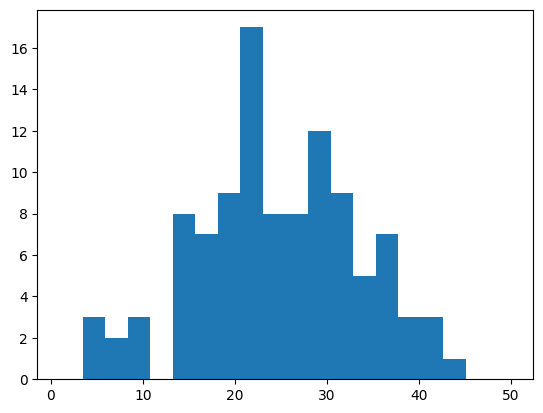

In [36]:


average_gas_ranks = pd.DataFrame(df_gas.loc[~df_gas['supplier'].isin(no_strat_gas_suppliers.index)].groupby('supplier')['rank'].mean())
average_power_ranks = pd.DataFrame(df_power.loc[~df_power['supplier'].isin(no_strat_pow_suppliers.index)].groupby('supplier')['rank'].mean())


#plt.hist(average_gas_ranks, range = (1, 50), bins = 20)
plt.hist(average_power_ranks, range = (1, 50), bins = 20)


In [37]:
bins = [1,2,3,4,5]
cutoffs = [0, 9, 19, 29, 39, 49]
average_gas_ranks['strat_index'] = pd.cut(average_gas_ranks['rank'], bins = cutoffs, labels = bins)
average_power_ranks['strat_index'] = pd.cut(average_power_ranks['rank'], bins = cutoffs, labels = bins)

In [38]:
#Adding Strategy Indices to Datasets
df_power = df_power.merge(average_power_ranks[['strat_index']], how = 'left', left_on = 'supplier', right_on = average_power_ranks.index)
df_gas = df_gas.merge(average_gas_ranks[['strat_index']], how = 'left', left_on = 'supplier', right_on = average_gas_ranks.index)

In [41]:
#Filling Strategy Index NAs with index value 0, since they are outside of the top 50 for most postcodes
df_power['strat_index'] = df_power['strat_index'].fillna(0)
df_gas['strat_index'] = df_gas['strat_index'].fillna(0)

In [42]:
#Replacing invalid date_valid_to dates with max date in date_valid_from
max_valid_to = df_power.date_valid_from.max()
df_gas['date_valid_to'] = df_gas['date_valid_to'].str.replace('9999-12-31', str(max_valid_to))
df_power['date_valid_to'] = df_power['date_valid_to'].str.replace('9999-12-31', str(max_valid_to))

#Converting validity dates to datetimes
df_gas['date_valid_to'] = pd.to_datetime(df_gas['date_valid_to'])
df_power['date_valid_to'] = pd.to_datetime(df_power['date_valid_to'])

#Building validity period features
df_gas['validity_period'] = (df_gas['date_valid_to'] - df_gas['date_valid_from']).dt.days
df_power['validity_period'] = (df_power['date_valid_to'] - df_power['date_valid_from']).dt.days

In [1]:
#Building validity period features
df_gas['validity_period'] = (df_gas['date_valid_to'] - df_gas['date_valid_from']).dt.days
df_power['validity_period'] = (df_power['date_valid_to'] - df_power['date_valid_from']).dt.days

NameError: name 'df_gas' is not defined

In [44]:
df_gas.to_csv(path + "master_" + file_gas, index = False)
df_power.to_csv(path + "master_" + file_power, index = False)

In [60]:
df_power_prices.to_csv(path + 'power_prices')

In [46]:
df_gas_prices.to_csv(path + 'gas_prices')